# Image Processing SS 20 - Assignment - 02

### Deadline is 6.5.2020 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.


# Exercise 1 - 10 Points

Implement affine transformation with [bicubic interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation).
Implement the functions `affine_transformation` and `bicubic_interpolation`

In [89]:
# display the plots inside the notebook
%matplotlib inline

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

The [skimage](http://scikit-image.org/) library comes with multiple useful test images.  Let's start with an image of an astronaut. 

In [91]:
from skimage.data import astronaut
from skimage.color import rgb2gray

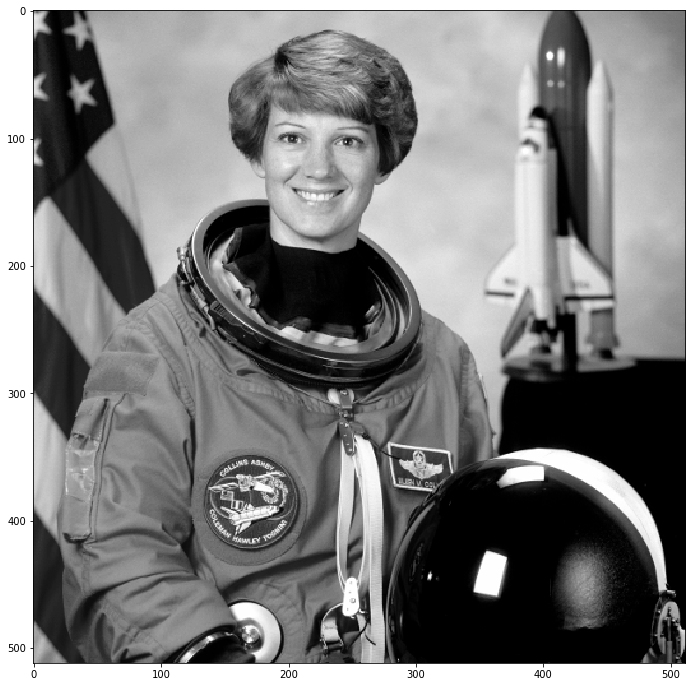

In [92]:
# We use a gray image. All the algorithms should work with color images too.
img = rgb2gray(astronaut() / 255.)
plt.imshow(img, cmap='gray')
plt.show()

In [93]:
def derive_y(image):
    """Computes the derivative of the image w.r.t the y coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if y + 1 < image.shape[1] and y - 1 > 0:
                derived_image[x,y] = image[x, y - 1] - image[x, y + 1]
    return derived_image

def derive_x(image):
    """Computes the derivative of the image w.r.t the x coordinate"""
    derived_image = np.zeros_like(image)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if x + 1 < image.shape[1] and x - 1 > 0:
                derived_image[x,y] = image[x - 1, y] - image[x + 1, y]
    return derived_image

In [94]:
dx_img = derive_x(img)
dy_img = derive_y(img)

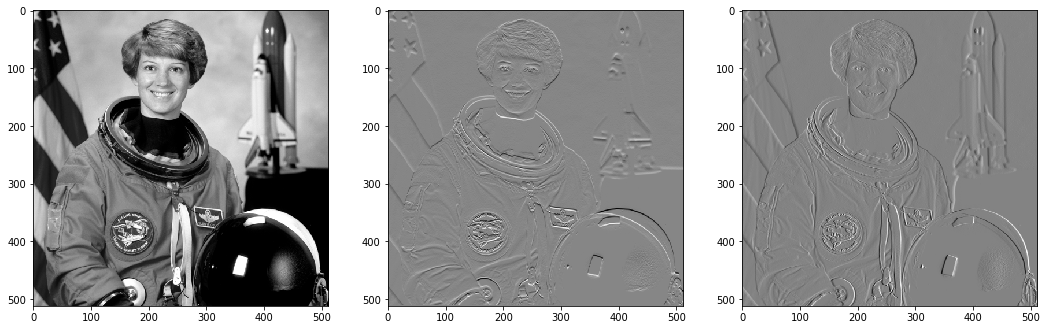

In [95]:
plt.figure(figsize=(18, 12))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(dx_img, cmap='gray')
plt.subplot(133)
plt.imshow(dy_img, cmap='gray')
plt.show()

In [96]:
# The derivatives are no longer in the range [0,1].
print("min: {}, max: {}".format(dx_img.min(), dx_img.max()))

min: -0.9896796078431372, max: 0.8965913725490197


In [97]:
indicies = np.indices(img.shape).reshape(2, -1)
img.shape
#indicies.shape

(512, 512)

In [98]:
# pick some random index

In [99]:
indicies[:, 512]

array([1, 0])

In [100]:
indicies_hg = np.concatenate([
        indicies, np.ones((1, indicies.shape[1]))], axis=0)
indicies_hg.shape

(3, 262144)

In [101]:
indicies_hg[:, 123456]

array([241.,  64.,   1.])

In [116]:
T_scale1 = np.array([
    [3, 0, 0],
    [0, 3, 0],
    [0, 0, 1],
])
# np.dot(T_affine, indicies_hg).shape, for python < 3.5
(T_scale @ indicies_hg).shape

(3, 262144)

In [103]:
T_affine = np.array([
    [0.75, 0.3, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])

In [117]:
T_scale = np.array([
    [0.75, 0, 0],
    [0, 0.75, 0],
    [0, 0, 1],
])

In [104]:
# you can use this function to invert the matricies
np.linalg.inv(T_scale)

array([[0.5, 0. , 0. ],
       [0. , 0.5, 0. ],
       [0. , 0. , 1. ]])

In [123]:
def affine_transformation(img, matrix):
    dx_img = derive_x(img)
    dy_img = derive_y(img)
    dxy_img = derive_x(dy_img)
    x,y, = img.shape
    size = int(np.amax(np.array([x,y,1]) @ matrix) ) + 1
    img_transformed = np.ones(( size ,  size))
    for i in range(size):
        for j in range(size):
            cord = np.array([i,j,1])            # indicies of the new picture
            indicies = np.linalg.inv(matrix)@ cord # inverse of matrix to see, where the pixel was before
            interpolated = bicubic_interpolation(img, indicies,dx_img,dy_img,dxy_img) # interpolate
            img_transformed[ i , j ] = interpolated 
        
    return img_transformed

In [124]:
def bicubic_interpolation(img, indicies,dx_img,dy_img,dxy_img):
 
    row, col = img.shape
    x,y = int(indicies[0]), int (indicies[1])        

    if(x == 0 or x >= row - 1 or y == 0 or y >= col - 1):
        return 0
    
    x1 = x + 1
    y1 = y + 1

    px = img[x,y]
    py = img[x,y]

    X = np.array([ img[x,y], img[x1,y],img[x,y1],img[x1,y1],
                   dx_img[x,y],dx_img[x1,y],dx_img[x,y1],dx_img[x1,y1],
                   dy_img[x,y],dy_img[x1,y],dy_img[x,y1],dy_img[x1,y1],
                   dxy_img[x,y],dxy_img[x1,y],dxy_img[x,y1],dxy_img[x1,y1],
                   ])

    A = np.array([ [1  ,0 , 0 ,0 , 0 , 0 , 0 , 0 , 0, 0 , 0 , 0 , 0 , 0 , 0 , 0],
                  [ 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 ],
                  [-3 , 3 , 0 , 0 , -2 , -1 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0],
                  [ 2 , -2 , 0 , 0 , 1 , 1 , 0 , 0 , 0, 0 , 0 , 0 , 0 , 0 , 0 , 0],
                  [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0 , 0 , 0 , 0, 0],
                  [0  ,0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 0],
                  [0 , 0 , 0 , 0 , 0 , 0 , 0 , 0 , -3 , 3 , 0 , 0 , -2, -1 , 0  ,0],
                  [0  ,0  ,0 ,0 , 0 , 0 , 0 , 0 , 2 , -2  ,0 , 0 , 1 , 1 , 0 , 0 ],
                  [-3 , 0 , 3 , 0 , 0 , 0 , 0 , 0, -2 , 0 , -1 , 0 , 0 , 0 , 0 , 0],
                  [0 , 0 , 0 , 0 , -3 , 0 , 3 , 0 , 0 , 0 , 0 , 0 , -2 , 0 , -1 , 0],
                  [9 , -9 , -9 , 9 , 6 , 3 , -6 , -3 , 6 , -6 , 3 , -3 , 4 , 2 , 2 , 1],
                  [-6 , 6 , 6 , -6, -3 , -3 , 3 , 3 , -4 , 4 , -2 , 2 , -2 , -2 , -1 , -1],
                  [2 ,0 , -2 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 1 , 0 , 0 , 0 , 0 , 0],
                  [0 , 0 , 0 , 0 , 2 , 0 , -2 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 1 ,0],
                  [-6 , 6 , 6 , -6, -4 , -2 , 4 ,2 , -3 , 3 , -3 , 3 ,-2 , -1, -2 , -1],
                  [4 , -4 , -4, 4 , 2 , 2 , -2 , -2 , 2 , -2 , 2 , -2, 1 , 1 , 1 , 1]
                ])
    alpha = A @ X
    alpha = alpha.reshape(4,4).T
    res = np.array([1,px,px**2,px**3]) @ alpha @ np.array([1,py,py**2,py**3])
    return res





     
    # your code here

In [125]:
img_scale = affine_transformation(img, T_scale)
#img_affine = affine_transformation(img, T_affine)

KeyboardInterrupt: 

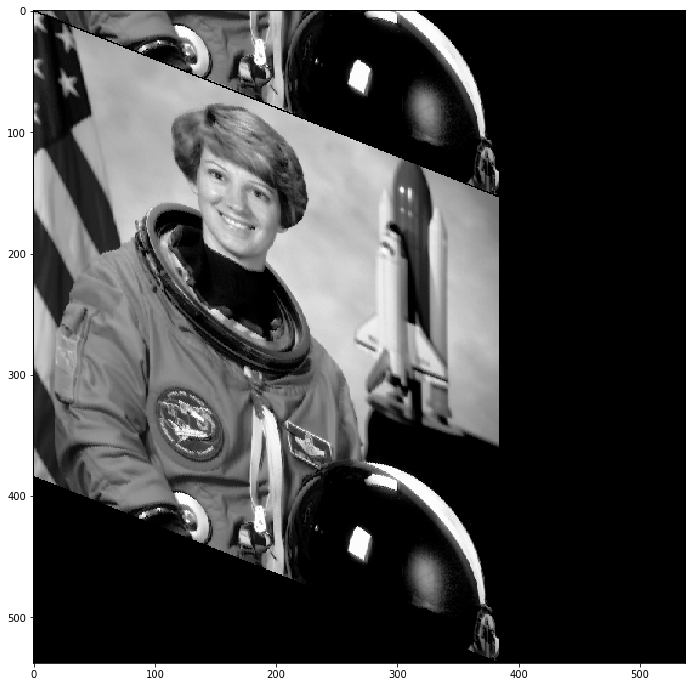

In [113]:
plt.imshow(img_affine, cmap='gray')
plt.show()


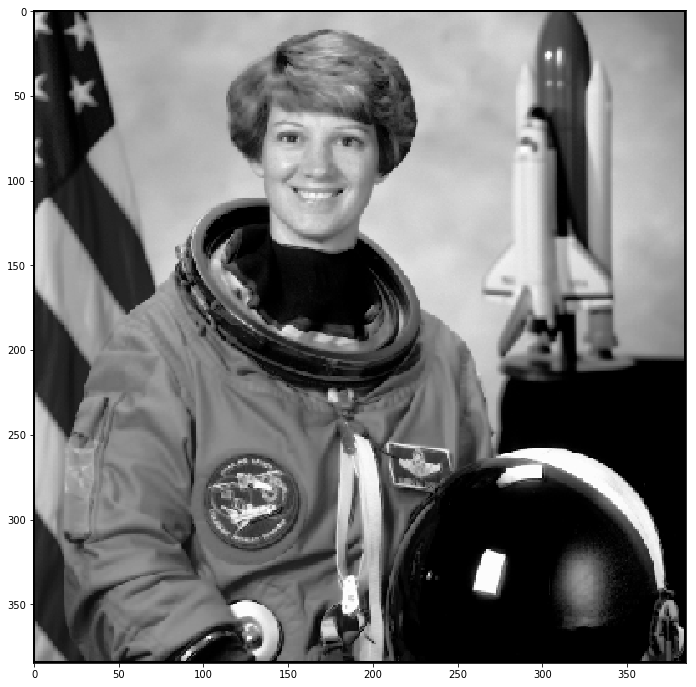

In [119]:
plt.imshow(img_scale, cmap='gray')
plt.show()

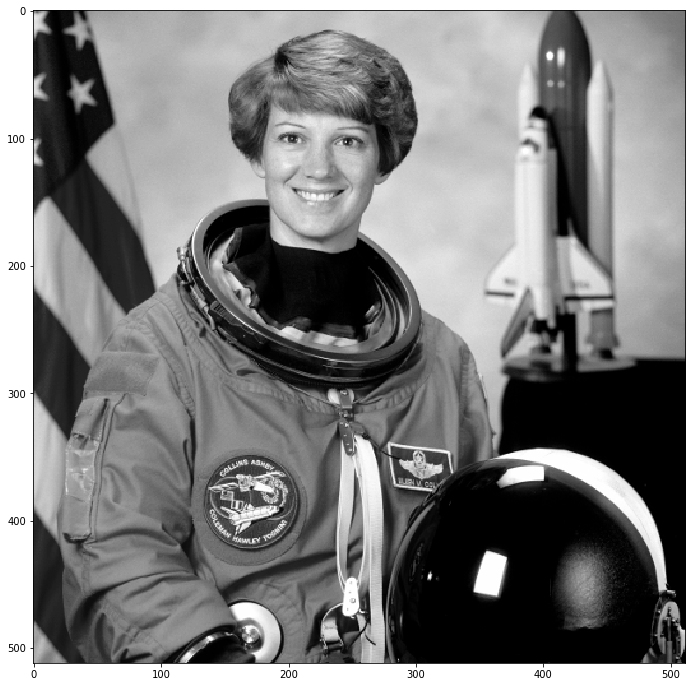

In [115]:
plt.imshow(img, cmap='gray')
plt.show()